In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
import pickle

import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import torch.nn.functional as F

from transformers.modeling_xlnet import XLNetLayerNorm, XLNetModel, XLNetPreTrainedModel, gelu
from transformers import *

from transformers import AdamW

from keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm, trange
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import multilabel_confusion_matrix, classification_report

SEED = 17

Using TensorFlow backend.


In [2]:
import logging
logging.basicConfig(format='%(asctime)s - %(levelname)s - %(name)s -   %(message)s',
                    datefmt='%m/%d/%Y %H:%M:%S',
                    filename='xlnet_dpcnn.log',
                    level=logging.INFO)
logger = logging.getLogger(__name__)

#### Setting up gpu environment

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla K80'

Preparing NYT dataset for *XLNet*


In [4]:
import pandas as pd
df_full = pd.read_parquet('../data/nyt_full.parquet.gz')

In [5]:
df_full.shape

(788503, 14)

In [6]:
# sample a small set of observations for testing 
#df = df_full.sample(10000, random_state=SEED)

# full dataset for the real deal
df = df_full

df = df.set_index("Id")

In [7]:
df[df.Health == 1].head()

,Text,World,Washington,New_York_and_Region,Front_Page,Business,US,Sports,Obituaries,Health,Education,Science,Technology
Id,,,,,,,,,,,,,
57,"LEAD: Nine months after the ""open adoption"" of...",0,0,0,0,0,0,0,0,1,0,0,0
118,"LEAD: Low-fat diets, widely recommended as a m...",0,0,0,0,0,1,0,0,1,0,0,0
217,LEAD: A Federal judge in New Orleans upheld a ...,0,0,0,0,0,0,1,0,1,0,0,0
307,"LEAD: Since he was 15 years old, James Henry M...",0,0,0,0,0,1,0,0,1,0,0,0
428,"LEAD: He practices with the team every day, sh...",0,0,0,0,0,0,1,0,1,0,0,0


In [8]:
tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased')

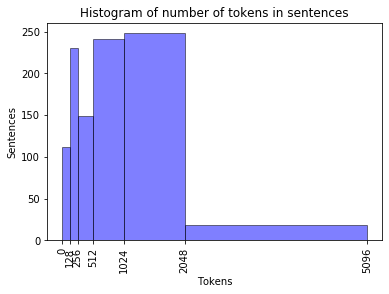

In [9]:
plt.hist(
    [len(s) for s in df.sample(1000)["Text"].apply(lambda x: tokenizer.tokenize(x))], 
    bins=[0, 128, 256, 512, 1024, 2048, 5096], 
    histtype='bar', 
    facecolor='b',
    edgecolor='k',
    alpha=0.5)
plt.xticks([0, 128, 256, 512, 1024, 2048, 5096], rotation='vertical')
plt.xlabel('Tokens')
plt.ylabel('Sentences')
plt.title('Histogram of number of tokens in sentences')
plt.show()

In [11]:
# Sentences larger than MAX_LEN are truncated (out-of-memory workaround)
MAX_LEN = 128

df_input_ids_full = df["Text"].copy()
XLNET_END_TOKEN_IDS = tokenizer.encode("[SEP][CLS]")

for i in tqdm(df_input_ids_full.index, desc="Tokenizer"):
  input_ids = tokenizer.convert_tokens_to_ids(
      tokenizer.tokenize(df_input_ids_full[i])[:MAX_LEN - len(XLNET_END_TOKEN_IDS)])
  df_input_ids_full.at[i] = input_ids + XLNET_END_TOKEN_IDS

df_input_ids_full.shape
# the code below causes out-of-memory crash and the code above was used

# convert to XLNet vocabulary tokens
#df["tokens"] = df["Text"].apply(lambda x: tokenizer.tokenize(x + " [SEP] [CLS]"))

# convert tokens to XLNet vocabulary ids
#df["input_ids_full"] = df["tokens"].apply(lambda x: tokenizer.convert_tokens_to_ids(x))

Tokenizer: 100%|██████████| 788503/788503 [43:14<00:00, 303.92it/s]  


(788503,)

In [12]:
# using Keras function to handle padding
df["input_ids"] = pad_sequences(
    df_input_ids_full, 
    maxlen=MAX_LEN, 
    dtype="long", 
    padding="post", 
    value=0).tolist()

# Create XLNet masks: 1 for tokens 0 for padding
attention_masks = []
for input_id in df.input_ids:
  mask = [int(i>0) for i in input_id]
  attention_masks.append(mask)
df["attention_masks"] = attention_masks

# Create XLNet segments: 0 for each token of the first sentence, 
# followed by a 1 for each token of the second sentence.  For one sentence 
# inputs, this is simply a sequence of 0s
df["segment_masks"] = np.zeros((df.shape[0], MAX_LEN), dtype=int).tolist()

In [13]:
# check for a observation with less than MAX_LEN tokens
for i in df.index:
  if(np.count_nonzero(df.loc[i, "input_ids"]) < 128):
    print("Index:", i)
    print(df.loc[i, "Text"])
    print(df.loc[i, "input_ids"])
    print(np.count_nonzero(df.loc[i, "input_ids"]))
    print(df.loc[i, "attention_masks"])
    print(np.count_nonzero(df.loc[i, "attention_masks"]))
    print(df.loc[i, "segment_masks"])
    print(np.count_nonzero(df.loc[i, "segment_masks"]))
    break


Index: 7
LEAD:
*3*** COMPANY REPORTS **
*3*CSP INC (OTC)
Qtr to Nov 30
1986
1985
Sales
2,523,000
3,998,000
Net inc
199,000
608,000
Share earns
.07
.21
*3*** COMPANY REPORTS **
*3*CSP INC (OTC)
Qtr to Nov 30
1986
1985
Sales
2,523,000
3,998,000
Net inc
199,000
608,000
Share earns
.07
.21
[657, 25834, 60, 6940, 233, 8652, 4684, 15382, 22415, 936, 9322, 24001, 83, 17, 4684, 6940, 233, 8652, 323, 7118, 7399, 17, 10, 7717, 323, 11, 2191, 7628, 22, 3796, 544, 4698, 5243, 7555, 159, 19, 4415, 9244, 198, 19, 2692, 6492, 3340, 25, 369, 1029, 9819, 1639, 6492, 9485, 4043, 23, 17, 9, 3761, 17, 9, 2306, 6940, 233, 8652, 4684, 15382, 22415, 936, 9322, 24001, 83, 17, 4684, 6940, 233, 8652, 323, 7118, 7399, 17, 10, 7717, 323, 11, 2191, 7628, 22, 3796, 544, 4698, 5243, 7555, 159, 19, 4415, 9244, 198, 19, 2692, 6492, 3340, 25, 369, 1029, 9819, 1639, 6492, 9485, 4043, 23, 17, 9, 3761, 17, 9, 2306, 4145, 83, 8186, 3158, 10849, 7416, 83, 3158, 0, 0, 0, 0, 0, 0, 0]
121
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

In [10]:
df.sample(5)

,Text,World,Washington,New_York_and_Region,Front_Page,Business,US,Sports,Obituaries,Health,Education,Science,Technology
Id,,,,,,,,,,,,,
722356,*3*** COMPANY REPORTS **\n*3*Marvel Entertainm...,0,0,0,0,1,0,0,0,0,0,0,0
310340,LEAD: The Bush Administration secretly renewed...,1,1,0,0,0,0,0,0,0,0,0,0
21066,LEAD: Astronomers say they have discovered tha...,0,0,0,0,0,1,0,0,0,0,1,0
811242,Holiday Discounts Begin\nAs the holiday shoppi...,0,0,0,0,0,1,0,0,0,0,0,0
552514,A 68-year-old Queens woman who said she shot h...,0,0,0,1,0,1,0,0,0,0,0,0


In [11]:
import os

MODEL_PATH = "../models/xlnet/nyt-full"

In [12]:
xlnet_ds_prepared = MODEL_PATH + "/xlnet_prepared_ds_parquet.gzip"

#df.to_parquet(xlnet_ds_prepared, compression='gzip')
df = pd.read_parquet(xlnet_ds_prepared)
#df = df.sample(50000, random_state = SEED)

#### Split training and test sets

In [13]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.2, random_state = SEED)

print(train_df.shape, test_df.shape)

(630802, 16) (157701, 16)


#### Put data into data loader

In [14]:
tt_train_input_ids = torch.tensor(train_df["input_ids"].tolist())
tt_test_input_ids = torch.tensor(test_df["input_ids"].tolist())

tt_train_attention_masks = torch.tensor(train_df["attention_masks"].tolist())
tt_test_attention_masks = torch.tensor(test_df["attention_masks"].tolist())

tt_train_segment_masks = torch.tensor(train_df["segment_masks"].tolist())
tt_test_segment_masks = torch.tensor(test_df["segment_masks"].tolist())

label_columns = [
  'World',
  'Washington',
  'New_York_and_Region',
  'Front_Page',
  'Business',
  'US',
  'Sports',
  'Obituaries',
  'Health',
  'Education',
  'Science',
  'Technology']

tt_train_labels = torch.tensor(train_df[label_columns].values.astype(np.float))
tt_test_labels = torch.tensor(test_df[label_columns].values.astype(np.float))

In [15]:
# training batch size
batch_num = 32

train_data = TensorDataset(
    tt_train_input_ids, 
    tt_train_attention_masks, 
    tt_train_segment_masks, 
    tt_train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(
    train_data, sampler=train_sampler, batch_size=batch_num,drop_last=True)

valid_data = TensorDataset(
    tt_test_input_ids, 
    tt_test_attention_masks, 
    tt_test_segment_masks, 
    tt_test_labels)
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(
    valid_data, sampler=valid_sampler, batch_size=batch_num)

#### DPCNN

In [16]:
class DPCNN(torch.nn.Module):
    def __init__(self, num_labels, channel_size=250, width=768):
        super(DPCNN, self).__init__()
        self.conv_embedding = torch.nn.Conv2d(1, channel_size, (3, width))
        self.conv2 = torch.nn.Conv2d(channel_size, channel_size, (3, 1))
        self.pooling = torch.nn.MaxPool2d(kernel_size=(3,1), stride=2)
        self.padding_conv = torch.nn.ZeroPad2d((0, 0, 1, 1))
        self.padding_pool = torch.nn.ZeroPad2d((0, 0, 0, 1))
        self.activation_function = torch.nn.ReLU()
        self.last_linear = torch.nn.Linear(channel_size, num_labels)
        self.channel_size = channel_size

    def forward(self, embeddings):
        
        batch_size, width, height = embeddings.shape

        # First transform the BERT embeddings (batch_size, num_characters, 768),
        # like (64, 80, 768)
        # to a 4D tensor like [64, 1, 80, 768] (required by the Conv2d)
        x = embeddings.view((batch_size, 1, width, height))

        # Run the first convolution (embedding). The output is [64, 250, 78, 1] 
        x = self.conv_embedding(x)
        #print(f'1 {x.shape}')        
        #x = self.activation_function(x)
        x_save = x

        # Run the second convolution. The output is [64, 250, 76, 1]
        x = self.conv2(x)
        #print(f'2 {x.shape}')

        # Add padding at starting and ending rows of the tensor. After that the
        # shape will be [64, 250, 78, 1]
        x = self.padding_conv(x)
        #x = self.activation_function(x)

        # Run another convolution. After that the shape will be [64, 250, 76, 1]
        x = self.conv2(x)
        x = self.padding_conv(x)
        x = x + self.activation_function(x_save)
        #print(f'3 {x.shape}')

        # Go over the blocks
        while x.shape[-2] >= 2:
            #print(x.shape)
            x = self.padding_pool(x)
            #print(f'3.1 {x.shape}')

            # Save the pool output to add that to the convolutions at the end
            pooling_x = self.pooling(x) 
            #print(f'pooling {pooling_x.shape}')

            # Perform the first convolution
            x = self.padding_conv(pooling_x)
            x = torch.nn.functional.relu(x)
            x = self.conv2(x)
            #print(f'4 {x.shape}')

            # Perform the second convolution
            x = self.padding_conv(x)
            x = F.relu(x)
            x = self.conv2(x)
            #print(f'5 {x.shape}')

            # Do the addition 
            x = x + pooling_x

        x = x.view(batch_size, self.channel_size)
        x = self.last_linear(x)
         
        return x

In [17]:
class XLNetDPCNN(XLNetPreTrainedModel):
    """XLNet model for multiple label classification."""
    def __init__(self, config):
        super(XLNetDPCNN, self).__init__(config)
        num_labels = len(label_columns)
        self.num_labels = num_labels
        self.xlnet = XLNetModel(config)
        self.dropout = torch.nn.Dropout(config.dropout)
        self.dpcnn = DPCNN(num_labels)
        self.classifier = torch.nn.Linear(num_labels, num_labels)

    def forward(self, 
                input_ids, 
                attention_mask=None, 
                mems=None, 
                perm_mask=None, 
                target_mapping=None,
                token_type_ids=None, 
                input_mask=None, 
                head_mask=None, 
                labels=None):
      
        transformer_outputs = self.xlnet(
            input_ids,
            attention_mask=attention_mask,
            mems=mems,
            perm_mask=perm_mask,
            target_mapping=target_mapping,
            token_type_ids=token_type_ids,
            input_mask=input_mask,
            head_mask=head_mask)

        output = transformer_outputs[0]
        x = self.dropout(output) 
        x = self.dpcnn(x)

        logits = self.classifier(x)

        outputs = (logits,) + transformer_outputs[1:]  # Keep mems, hidden states, attentions if there are in it

        if labels is not None:
            if self.num_labels == 1:
                #  We are doing regression
                loss_fct = torch.nn.MSELoss()
                loss = loss_fct(logits.view(-1), labels.view(-1))
            else:
                #  We multilabel multiclass
                loss_fct = torch.nn.BCEWithLogitsLoss()
                loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1, self.num_labels))
            outputs = (loss,) + outputs

        return outputs  # return (loss), logits, (mems), (hidden states), (attentions)



#### Custom Transformers

#### Load XLNet model

In [18]:
model = XLNetDPCNN.from_pretrained(
    'xlnet-base-cased', num_labels=len(label_columns))
model.cuda()

XLNetDPCNN(
  (xlnet): XLNetModel(
    (word_embedding): Embedding(32000, 768)
    (layer): ModuleList(
      (0): XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (layer_1): Linear(in_features=768, out_features=3072, bias=True)
          (layer_2): Linear(in_features=3072, out_features=768, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (1): XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tr

In [19]:
# Set epoch and grad max num
epochs = 5
max_grad_norm = 1.0

In [20]:
# Fine tune model all layer parameters
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
      'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
      'weight_decay_rate': 0.0}
]
    
optimizer = AdamW(optimizer_grouped_parameters, lr=3e-5)
optimizer

AdamW (
Parameter Group 0
    betas: (0.9, 0.999)
    correct_bias: True
    eps: 1e-06
    lr: 3e-05
    weight_decay: 0.0
    weight_decay_rate: 0.01

Parameter Group 1
    betas: (0.9, 0.999)
    correct_bias: True
    eps: 1e-06
    lr: 3e-05
    weight_decay: 0.0
    weight_decay_rate: 0.0
)

#### Fine-tuning the XLNet model

In [17]:
model.train()

XLNetDPCNN(
  (xlnet): XLNetModel(
    (word_embedding): Embedding(32000, 768)
    (layer): ModuleList(
      (0): XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (layer_1): Linear(in_features=768, out_features=3072, bias=True)
          (layer_2): Linear(in_features=3072, out_features=768, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (1): XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tr

In [ ]:
print("***** Running training *****")
print("  Num examples = %d"%(len(tt_train_input_ids)))
print("  Batch size = %d"%(batch_num))
for _ in trange(epochs,desc="Epoch"):
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0
    for step, batch in enumerate(train_dataloader):
        # add batch to gpu
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_segs, b_labels = batch
        
        # forward pass
        outputs = model(
            input_ids = b_input_ids, 
            token_type_ids = b_segs, 
            input_mask = b_input_mask,
            labels= b_labels)
        loss, logits = outputs[:2]
        if n_gpu>1:
            # When multi gpu, average it
            loss = loss.mean()
        
        # backward pass
        loss.backward()
        
        # track train loss
        tr_loss += loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1
        
        # gradient clipping
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)
        
        # update parameters
        optimizer.step()
        optimizer.zero_grad()
        
    # print train loss per epoch
    print("Train loss: {}".format(tr_loss/nb_tr_steps))

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

***** Running training *****
  Num examples = 630802
  Batch size = 32


Epoch:  20%|██        | 1/5 [11:50:36<47:22:26, 42636.54s/it]

Train loss: 0.11880640715441758


Epoch:  40%|████      | 2/5 [23:40:16<35:30:59, 42619.72s/it]

Train loss: 0.0921930052011127


Epoch:  60%|██████    | 3/5 [35:29:31<23:40:00, 42600.18s/it]

Train loss: 0.08571496863402037


#### Saving the model

In [ ]:
model_save_name = MODEL_PATH + "/pytorch_model.bin"
model_config_save_name = MODEL_PATH + "/config.json"
model_report_save_name = MODEL_PATH + "/eval_results.txt"

torch.save(model.state_dict(), model_save_name)
model.config.to_json_file(model_config_save_name)
tokenizer.save_vocabulary(MODEL_PATH)

#### Loading finetuned model

In [ ]:
model = XLNetDPCNN.from_pretrained(
    MODEL_PATH, num_labels=len(label_columns))
model.cuda()

#### Model evaluation

In [21]:
root_folder = '../bert'

def load_model(folder=MODEL_PATH):
    model = XLNetDPCNN.from_pretrained(MODEL_PATH, num_labels=len(label_columns))
    
    if n_gpu != 0:
        model.cuda()
      
    return model

def save_object(filename, obj, folder=root_folder):
    obj_file = os.path.join(folder, filename)

    if os.path.exists(obj_file):
        os.remove(obj_file)

    with open(obj_file, 'wb') as f:
        pickle.dump(obj, f)

def load_object(filename, folder=root_folder):
    object_file = os.path.join(folder, filename)

    with open(object_file, 'rb') as f:
        return pickle.load(f)

def calculate_confusion_matrix(data_loader, model, batch_size):
    model.eval()
    torch.cuda.empty_cache()
    predictions = []
    true_labels = []

    with torch.no_grad():
        for step, batch in enumerate(data_loader):
            # add batch to gpu
            if n_gpu != 0:
                batch = tuple(t.to('cuda') for t in batch)
            
            logger.info(f'Step {step}')
            #import pdb; pdb.set_trace()
            b_input_ids, b_input_masks, b_segment_ids, b_labels = batch
        
            # forward pass
            #raw_outputs = model(b_input_ids, b_segment_ids, b_input_masks)
            raw_outputs = model(input_ids = b_input_ids, token_type_ids = b_segment_ids, input_mask = b_input_masks)
            predictions.append((torch.sigmoid(raw_outputs[0]) > .5).cpu().numpy().astype(int))
            true_labels.append(b_labels.cpu().numpy().astype(int))

        true_labels = np.vstack(true_labels)[0:(batch_size * len(predictions)),]
        predictions = np.vstack(predictions)

        return (multilabel_confusion_matrix(true_labels, predictions),
                true_labels,
                predictions)

def calculate_predictions(data_loader, model, batch_size):
    if n_gpu != 0:
        model.cuda()
        torch.cuda.empty_cache()

    model.eval()
    result = None

    with torch.no_grad():
        for step, batch in enumerate(data_loader):
            logger.info(f'Step {step}')
            
            # add batch to gpu
            if n_gpu != 0:
                batch = tuple(t.to('cuda') for t in batch)
                
            b_input_ids, b_input_masks, b_segment_ids, b_labels = batch
        
            # forward pass
            raw_outputs = model(b_input_ids, b_segment_ids, b_input_masks)
            predictions = torch.sigmoid(raw_outputs[2]).cpu()
            predictions = predictions.numpy()
            result = predictions if result is None else np.append(result, predictions, axis=0)
            
        return result

def get_label_columns(data_frame):
    skip_columns =  { 'Id', 'Text', 'input_ids', 'attention_masks', 'segment_masks' }
    return [c for c in data_frame.columns if c not in skip_columns and '_Pred' not in c]

def add_predictions(data_frame, features, model, batch_size):
    logits = calculate_predictions(features, model, batch_size)
    predictions = (logits > .5).astype(int)
    
    for i, column_name in enumerate(get_label_columns(data_frame)):
        data_frame[f'{column_name}_Pred'] = predictions[:, i]

def add_predictions_to_dataframe(data_frame, predictions):
    for i, column_name in enumerate(get_label_columns(data_frame)):
        data_frame[f'{column_name}_Pred'] = predictions[:, i]
        
class ModelResult:
    def __init__(self, data_frame, features, model, batch_size):
        confusion_matrix, labels, predictions = calculate_confusion_matrix(features, model, batch_size)
        self.confusion_matrix = confusion_matrix
        self.labels = labels
        self.predictions = predictions
        self.label_columns = get_label_columns(data_frame)
        
    def save(self, filename):
        save_object(filename, self)
        
    def get_classification_report(self, output_dictionary):
        return classification_report(self.labels, self.predictions, 
                                     target_names=self.label_columns, 
                                     output_dict=output_dictionary)
        
    def get_results_dataframe(self):
        report_dict = self.get_classification_report(True)
        label_columns = list(self.label_columns)
        label_columns.append('weighted avg')
        classification_results = pd.DataFrame({'Label':label_columns})
        classification_results['Precision'] = [report_dict[c]['precision'] for c in label_columns]
        classification_results['Recall'] = [report_dict[c]['recall'] for c in label_columns]
        classification_results['F1-Score'] = [report_dict[c]['f1-score'] for c in label_columns]
        classification_results['Support'] = [report_dict[c]['support'] for c in label_columns]
        classification_results.loc[classification_results['Label'] == 'weighted avg', 'Label'] = 'Weighted Average'
        
        return classification_results

In [22]:
model = load_model()

In [23]:
model_results = ModelResult(test_df, valid_dataloader, model, 100)

In [24]:
model_results.save('xlnet_dpcnn_result_test.pkl')

In [25]:
model_results = load_object('xlnet_dpcnn_result_test.pkl')
model_results.label_columns = get_label_columns(test_df)

In [26]:
add_predictions_to_dataframe(test_df, model_results.predictions)

/home/marceloblinder/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


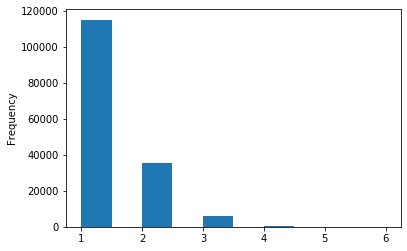

In [27]:
test_df[get_label_columns(test_df)].sum(1).plot.hist()

In [28]:
model_results.get_results_dataframe()

/home/marceloblinder/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


,Label,Precision,Recall,F1-Score,Support
0,World,0.893904,0.781685,0.834037,24144
1,Washington,0.732223,0.543867,0.624144,9050
2,New_York_and_Region,0.897221,0.885716,0.891431,35718
3,Front_Page,0.962316,0.334282,0.496198,5271
4,Business,0.960247,0.948227,0.954199,43382
5,US,0.733744,0.726998,0.730355,34040
6,Sports,0.975728,0.965868,0.970773,33546
7,Obituaries,0.986906,0.984075,0.985489,6970
8,Health,0.826547,0.482217,0.609086,7451
9,Education,0.700000,0.255731,0.374607,1396


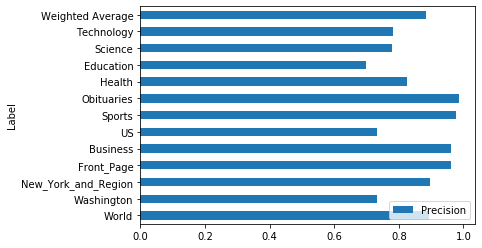

In [29]:
model_results.get_results_dataframe().plot.barh(x='Label', y='Precision')

#### Number of matches

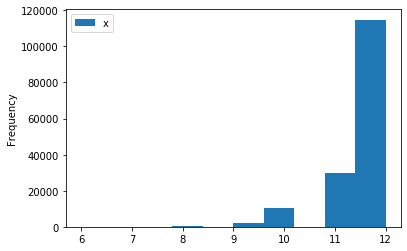

In [30]:
pd.DataFrame({'x':((model_results.labels == model_results.predictions).astype(int).sum(1))}).plot.hist()

In [ ]:
model.eval();

In [ ]:
# Softtmax accuracy
#def accuracy(out, labels):
#    outputs = np.argmax(out, axis=1)
#    return np.sum(outputs == labels)

# Multilabel accuracy
def accuracy(y_pred, y_true, thresh=0.5):
    "Compute accuracy when `y_pred` and `y_true` are the same size."
    return np.mean(((y_pred > thresh) == y_true), axis=1).sum()

In [ ]:
eval_loss, eval_accuracy = 0, 0
nb_eval_steps, nb_eval_examples = 0, 0

all_logits = None
all_labels = None

print("***** Running evaluation *****")
print("  Num examples ={}".format(len(tt_test_input_ids)))
print("  Batch size = {}".format(batch_num))

for step, batch in enumerate(valid_dataloader):
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_segs,b_labels = batch
    
    with torch.no_grad():
        outputs = model(
            input_ids = b_input_ids,
            token_type_ids = b_segs, 
            input_mask = b_input_mask,
            labels = b_labels)
        tmp_eval_loss, logits = outputs[:2]
    
    # Get textclassification predict result
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    tmp_eval_accuracy = accuracy(logits, label_ids)
    
    # Save predict and real label reuslt for analyze
    if all_logits is None:
        all_logits = logits
    else:
        all_logits = np.concatenate((all_logits, logits), axis=0)
        
    if all_labels is None:
        all_labels = label_ids
    else:    
        all_labels = np.concatenate((all_labels, label_ids), axis=0)

    eval_loss += tmp_eval_loss.mean().item()
    eval_accuracy += tmp_eval_accuracy
   
    nb_eval_steps += 1


    
eval_loss = eval_loss / nb_eval_steps
eval_accuracy = eval_accuracy / len(tt_test_input_ids)

#     ROC-AUC calcualation
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(label_columns)):
    fpr[i], tpr[i], _ = roc_curve(all_labels[:, i], all_logits[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(all_labels.ravel(), all_logits.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

result = {'eval_loss': eval_loss,
          'eval_accuracy': eval_accuracy,
          'roc_auc': roc_auc}

with open(model_report_save_name, "w") as writer:
    logger.info("***** Eval results *****")
    for key in sorted(result.keys()):
        logger.info("  %s = %s", key, str(result[key]))
        writer.write("%s = %s\n" % (key, str(result[key])))

In [ ]:
result